In [83]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
%matplotlib inline
import warnings

plt.style.use('seaborn-poster')
warnings.filterwarnings("ignore")

confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/01-15-2023.csv')

latest_data.head()



,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio
0,NaN,NaN,NaN,Afghanistan,2023-01-16 04:21:05,33.93911,67.709953,207900,7854,NaN,NaN,Afghanistan,534.058207,3.777778
1,NaN,NaN,NaN,Albania,2023-01-16 04:21:05,41.15330,20.168300,334037,3596,NaN,NaN,Albania,11607.373688,1.076527
2,NaN,NaN,NaN,Algeria,2023-01-16 04:21:05,28.03390,1.659600,271287,6881,NaN,NaN,Algeria,618.655752,2.536428
3,NaN,NaN,NaN,Andorra,2023-01-16 04:21:05,42.50630,1.521800,47781,165,NaN,NaN,Andorra,61840.419336,0.345326
4,NaN,NaN,NaN,Angola,2023-01-16 04:21:05,-11.20270,17.873900,105095,1930,NaN,NaN,Angola,319.765542,1.836434


In [84]:
confirmed_df.head()
#deaths_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288


In [85]:
confirmed = confirmed_df.loc[:, confirmed_cols[4]:]
deaths = deaths_df.loc[:, deaths_cols[4]:]
confirmed_dates = confirmed.iloc[0].index.tolist()
death_dates = deaths.iloc[0].index.tolist()
confirmed.keys()
print(confirmed_dates)

['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20', '1/30/20', '1/31/20', '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20', '2/6/20', '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20', '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20', '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20', '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '3/1/20', '3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20', '3/9/20', '3/10/20', '3/11/20', '3/12/20', '3/13/20', '3/14/20', '3/15/20', '3/16/20', '3/17/20', '3/18/20', '3/19/20', '3/20/20', '3/21/20', '3/22/20', '3/23/20', '3/24/20', '3/25/20', '3/26/20', '3/27/20', '3/28/20', '3/29/20', '3/30/20', '3/31/20', '4/1/20', '4/2/20', '4/3/20', '4/4/20', '4/5/20', '4/6/20', '4/7/20', '4/8/20', '4/9/20', '4/10/20', '4/11/20', '4/12/20', '4/13/20', '4/14/20', '4/15/20', '4/16/20', '4/17/20', '4/18/20', '4/19/20', '4/20/20', '4/21/20', '4/22/20', '4/23/20', '4/

In [86]:
num_dates = len(confirmed.keys())
ck = confirmed.keys()
dk = deaths.keys()

world_cases = []
total_deaths = [] 
mortality_rate = []


for i in range(num_dates):
    confirmed_sum = confirmed[ck[i]].sum()
    death_sum = deaths[dk[i]].sum()
    
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    
    # calculate rates
    mortality_rate.append(death_sum/confirmed_sum)


[[797.1428571428571, 801.7142857142857, 1082.857142857143, 1283.2857142857142, 1514.4285714285713, 2095.285714285714, 2422.5714285714284, 2617.0, 3067.8571428571427, 3224.1428571428573, 3496.1428571428573, 3584.714285714286, 3339.285714285714, 3269.1428571428573, 2987.8571428571427, 2512.5714285714284, 4225.428571428572, 4644.571428571428, 4560.571428571428, 4439.428571428572, 4357.428571428572, 4334.428571428572, 4346.142857142857, 2261.714285714286, 1419.142857142857, 1364.7142857142858, 1107.4285714285713, 897.8571428571429, 751.0, 818.4285714285714, 930.2857142857143, 1043.7142857142858, 1059.2857142857142, 1344.5714285714287, 1546.2857142857142, 1797.4285714285713, 1993.4285714285713, 2192.8571428571427, 2558.5714285714284, 2882.285714285714, 3085.0, 3415.714285714286, 3722.4285714285716, 4455.571428571428, 5029.285714285715, 6345.0, 7309.428571428572, 8371.57142857143, 9839.0, 11326.857142857143, 12767.57142857143, 15672.0, 18005.714285714286, 21082.714285714286, 24365.4285714285

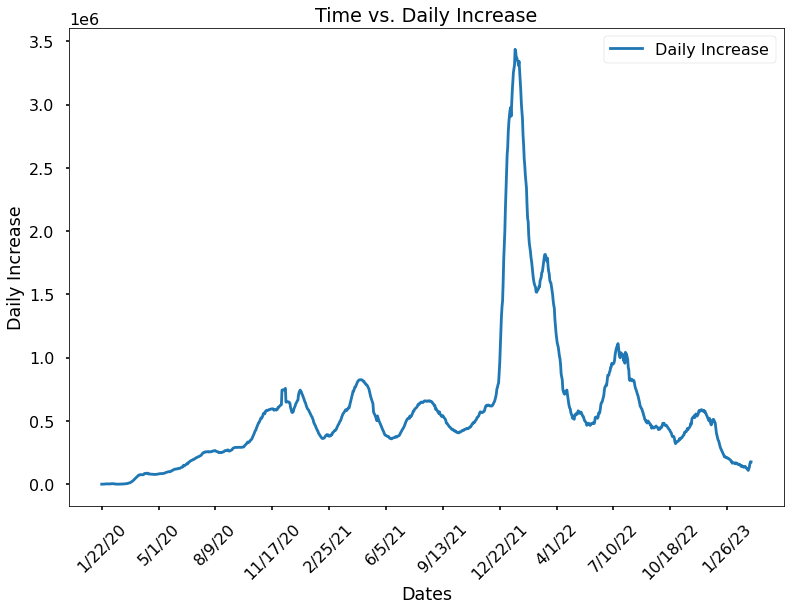

In [87]:
def daily_increase(data):
    d = []
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d

def moving_average(data, window_size):
    moving_average = []
    for i in range(len(data)):
        if i + window_size < len(data):
            moving_average.append(sum(data[i:i+window_size])/window_size)
        else:
            moving_average.append(sum(data[i:])/len(data[i:]))
    return moving_average
# window size: allows how much data to group
window = 7

# confirmed cases
world_daily_increase = daily_increase(world_cases)
world_confirmed_avg= moving_average(world_cases, window)
world_daily_increase_avg = moving_average(world_daily_increase, window)

# deaths
world_daily_death = daily_increase(total_deaths)
world_death_avg = moving_average(total_deaths, window)
world_daily_death_avg = moving_average(world_daily_death, window)

plot_data = [world_daily_increase_avg, world_daily_death_avg]
print(plot_data)
plt.plot(confirmed_dates, world_daily_increase_avg, label='Daily Increase')
#plt.plot(deaths_dates, world_daily_death_avg, label='Daily Deaths')
plt.xlabel('Dates')
x = range(0,len(confirmed_dates), 100)
plt.xticks(x, [confirmed_dates[i] for i in x], rotation=45)
plt.ylabel('Daily Increase')
plt.title('Time vs. Daily Increase')
plt.legend()
plt.show()

        

In [94]:
#future forecasting 
days_in_future = 10
future_forcast = np.array([i for i in range(len(ck)+days_in_future)]).reshape(-1,1)
adjusted_dates = future_forcast[:-10]
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

future_forcast_dates = future_forcast_dates[-10:]
future_forcast_avg = moving_average(future_forcast, window)
